In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Relaxation Procedures
###  The Descent Algorithm

The **criterion function** $ J_p $ is not the only function we can minimize to find a solution vector $ \mathbf{a} $. A closely related function is defined as:

$$
J_q (\mathbf{a}) = \sum_{\mathbf{y} \in Y} (\mathbf{a}^T \mathbf{y})^2,
$$

where $ Y(\mathbf{a}) $ denotes the set of training samples misclassified by $ \mathbf{a} $. 

#### Issues with $ J_q $:
1. Its gradient is continuous, making it smoother to search, but it can converge to a boundary point $ \mathbf{a} = 0 $.
2. The criterion value can be dominated by the longest sample vectors.

To address these, we use the **relaxation criterion function**:

$$
J_r (\mathbf{a}) = \frac{1}{2} \sum_{\mathbf{y} \in Y} \frac{(\mathbf{a}^T \mathbf{y} - b)^2}{\|\mathbf{y}\|^2},
$$

where:
- $ Y(\mathbf{a}) $ is the set of samples for which $ \mathbf{a}^T \mathbf{y} \leq b $.
- $ J_r(\mathbf{a}) \geq 0 $, and $ J_r(\mathbf{a}) = 0 $ if and only if $ \mathbf{a}^T \mathbf{y} \geq b $ for all training samples.

#### Gradient of $ J_r $:
The gradient of $ J_r $ is given by:

$$
\nabla J_r = \sum_{\mathbf{y} \in Y} \frac{\mathbf{a}^T \mathbf{y} - b}{\|\mathbf{y}\|^2} \mathbf{y}.
$$

#### Update Rule:
The weight update rule is:

$$
\mathbf{a}(k+1) = \mathbf{a}(k) + \eta(k) \sum_{\mathbf{y} \in Y} \frac{b - \mathbf{a}^T(k) \mathbf{y}}{\|\mathbf{y}\|^2} \mathbf{y}.
$$

### Algorithm 8: Batch Relaxation with Margin

$$
\begin{aligned}
1. & \ \text{initialize } \mathbf{a}, \eta(\cdot), k = 0 \\
2. & \ \text{do} \\
3. & \ \ \ \ k \leftarrow k + 1 \\
4. & \ \ \ \ Y_k = \{\} \\
5. & \ \ \ \ \text{for } j = 1, \ldots, n: \\
6. & \ \ \ \ \ \ \ \ \text{if } \mathbf{a}^T \mathbf{y}_j \leq b, \text{ append } \mathbf{y}_j \text{ to } Y_k \\
7. & \ \ \ \ \text{end for} \\
8. & \ \ \ \ \mathbf{a} \leftarrow \mathbf{a} + \eta(k) \sum_{\mathbf{y} \in Y_k} \frac{b - \mathbf{a}^T \mathbf{y}}{\|\mathbf{y}\|^2} \mathbf{y} \\
9. & \ \text{until } Y_k = \{\} \\
10. & \ \text{return } \mathbf{a} \\
\end{aligned}
$$

### Single-Sample Relaxation Rule

For single-sample corrections, the update rule becomes:

$$
\mathbf{a}(k+1) = \mathbf{a}(k) + \eta \frac{b - \mathbf{a}^T(k) \mathbf{y}_k}{\|\mathbf{y}_k\|^2} \mathbf{y}_k,
$$

where $ \mathbf{a}^T(k) \mathbf{y}_k \leq b $.

#### Algorithm: Single-Sample Relaxation
$$
\begin{aligned}
1. & \ \text{initialize } \mathbf{a}, \eta, k = 0 \\
2. & \ \text{do} \\
3. & \ \ \ \ \text{select a misclassified sample } \mathbf{y}_k \text{ such that } \mathbf{a}^T(k) \mathbf{y}_k \leq b \\
4. & \ \ \ \ \mathbf{a}(k+1) \leftarrow \mathbf{a}(k) + \eta \frac{b - \mathbf{a}^T(k) \mathbf{y}_k}{\|\mathbf{y}_k\|^2} \mathbf{y}_k \\
5. & \ \text{until all samples are classified correctly} \\
6. & \ \text{return } \mathbf{a} \\
\end{aligned}
$$


In [1]:
import numpy as np

class RelaxationPerceptron:
    def __init__(self, eta=0.1, margin=1.0, max_iter=1000):
        """
        Initialize the relaxation perceptron parameters.
        :param eta: Learning rate (fixed increment value)
        :param margin: Margin (b)
        :param max_iter: Maximum number of iterations
        """
        self.eta = eta
        self.margin = margin
        self.max_iter = max_iter
        self.weights = None

    def fit_batch(self, X, y):
        """
        Batch relaxation algorithm.
        :param X: Feature matrix (n_samples, n_features)
        :param y: Labels vector (n_samples,)
        :return: Weight vector
        """
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)  # Initialize weights
        
        for _ in range(self.max_iter):
            misclassified = []
            for i in range(n_samples):
                if y[i] * np.dot(self.weights, X[i]) <= self.margin:
                    misclassified.append(i)
            
            if not misclassified:  # All samples are correctly classified
                break
            
            gradient = np.zeros(n_features)
            for i in misclassified:
                gradient += (self.margin - y[i] * np.dot(self.weights, X[i])) / (np.linalg.norm(X[i])**2) * y[i] * X[i]
            
            self.weights += self.eta * gradient

        return self.weights

    def fit_single_sample(self, X, y):
        """
        Single-sample relaxation algorithm.
        :param X: Feature matrix (n_samples, n_features)
        :param y: Labels vector (n_samples,)
        :return: Weight vector
        """
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)  # Initialize weights

        for _ in range(self.max_iter):
            for i in range(n_samples):
                if y[i] * np.dot(self.weights, X[i]) <= self.margin:
                    correction = (self.margin - y[i] * np.dot(self.weights, X[i])) / (np.linalg.norm(X[i])**2)
                    self.weights += self.eta * correction * y[i] * X[i]
            if all(y[i] * np.dot(self.weights, X[i]) > self.margin for i in range(n_samples)):
                break

        return self.weights

    def predict(self, X):
        """
        Predict the class of given samples.
        :param X: Feature matrix (n_samples, n_features)
        :return: Predicted labels
        """
        return np.sign(np.dot(X, self.weights))


In [2]:
# Example dataset: linearly separable data
X = np.array([[2, 1], [1, -1], [-1, -1], [-2, -2]])
y = np.array([1, 1, -1, -1])  # Labels

# Create relaxation perceptron instance
relaxation = RelaxationPerceptron(eta=0.1, margin=1.0, max_iter=1000)

# Batch relaxation fit
weights_batch = relaxation.fit_batch(X, y)
print("Weights from Batch Relaxation:", weights_batch)

# Single-sample relaxation fit
weights_single = relaxation.fit_single_sample(X, y)
print("Weights from Single-Sample Relaxation:", weights_single)

# Predict using the trained model
predictions = relaxation.predict(X)
print("Predictions:", predictions)


Weights from Batch Relaxation: [1.00000000e+00 5.14662591e-17]
Weights from Single-Sample Relaxation: [1.00000000e+00 5.18589318e-17]
Predictions: [ 1.  1. -1. -1.]


In [3]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

class RelaxationPerceptron:
    def __init__(self, eta=0.1, margin=1.0, max_iter=1000):
        """
        Initialize the relaxation perceptron parameters.
        :param eta: Learning rate (fixed increment value)
        :param margin: Margin (b)
        :param max_iter: Maximum number of iterations
        """
        self.eta = eta
        self.margin = margin
        self.max_iter = max_iter
        self.weights = []

    def dot_product(self, vec1, vec2):
        """Compute the dot product of two vectors."""
        return sum(v1 * v2 for v1, v2 in zip(vec1, vec2))

    def vector_norm(self, vec):
        """Compute the norm (magnitude) of a vector."""
        return math.sqrt(sum(v ** 2 for v in vec))

    def vector_add(self, vec1, vec2):
        """Add two vectors."""
        return [v1 + v2 for v1, v2 in zip(vec1, vec2)]

    def scalar_multiply(self, scalar, vec):
        """Multiply a vector by a scalar."""
        return [scalar * v for v in vec]

    def fit_batch(self, X, y):
        """
        Batch relaxation algorithm.
        :param X: Feature matrix (list of lists)
        :param y: Labels list
        :return: Weight vector
        """
        self.weights = [0] * len(X[0])  # Initialize weights
        
        for _ in range(self.max_iter):
            misclassified = []
            for i, x in enumerate(X):
                if y[i] * self.dot_product(self.weights, x) <= self.margin:
                    misclassified.append(i)
            
            if not misclassified:  # All samples are correctly classified
                break
            
            gradient = [0] * len(X[0])
            for i in misclassified:
                correction = (self.margin - y[i] * self.dot_product(self.weights, X[i])) / (self.vector_norm(X[i]) ** 2)
                gradient = self.vector_add(gradient, self.scalar_multiply(correction * y[i], X[i]))
            
            self.weights = self.vector_add(self.weights, self.scalar_multiply(self.eta, gradient))
        
        return self.weights

    def fit_single_sample(self, X, y):
        """
        Single-sample relaxation algorithm.
        :param X: Feature matrix (list of lists)
        :param y: Labels list
        :return: Weight vector
        """
        self.weights = [0] * len(X[0])  # Initialize weights

        for _ in range(self.max_iter):
            for i, x in enumerate(X):
                if y[i] * self.dot_product(self.weights, x) <= self.margin:
                    correction = (self.margin - y[i] * self.dot_product(self.weights, x)) / (self.vector_norm(x) ** 2)
                    self.weights = self.vector_add(self.weights, self.scalar_multiply(self.eta * correction * y[i], x))
            
            if all(y[i] * self.dot_product(self.weights, X[i]) > self.margin for i in range(len(X))):
                break
        
        return self.weights

    def predict(self, X):
        """
        Predict the class of given samples.
        :param X: Feature matrix (list of lists)
        :return: Predicted labels
        """
        return [1 if self.dot_product(self.weights, x) > 0 else -1 for x in X]

    def visualize(self, X, y):
        """
        Visualize the dataset and decision boundary using Seaborn.
        :param X: Feature matrix (list of lists)
        :param y: Labels list
        """
        sns.set(style="whitegrid")
        colors = ['blue' if label == 1 else 'red' for label in y]
        x1, x2 = zip(*X)

        # Plot points
        plt.scatter(x1, x2, c=colors, s=50, label="Data Points")

        # Plot decision boundary
        x_vals = [min(x1) - 1, max(x1) + 1]
        y_vals = [
            -(self.weights[0] * x + self.weights[2]) / self.weights[1] if len(self.weights) > 2 else 0
            for x in x_vals
        ]
        plt.plot(x_vals, y_vals, 'k--', label="Decision Boundary")

        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.title("Relaxation Perceptron Decision Boundary")
        plt.legend()
        plt.show()


Weights from Batch Relaxation: [0.9999999999999994, 5.1466259131060773e-17]
Weights from Single-Sample Relaxation: [0.999999999999999, 5.185893175926436e-17]
Predictions: [1, 1, -1, -1]


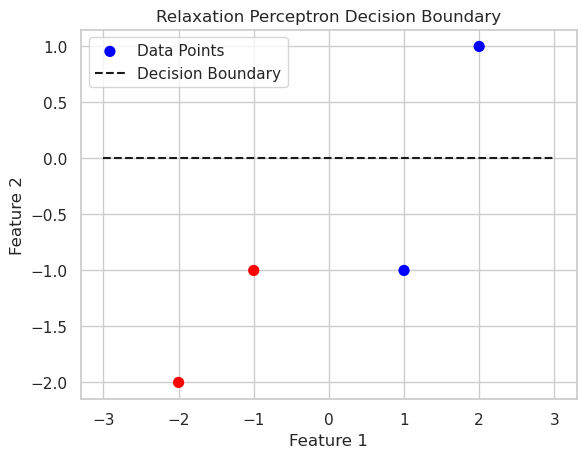

In [4]:
# Example dataset: linearly separable data
X = [[2, 1], [1, -1], [-1, -1], [-2, -2]]
y = [1, 1, -1, -1]  # Labels

# Create relaxation perceptron instance
relaxation = RelaxationPerceptron(eta=0.1, margin=1.0, max_iter=1000)

# Batch relaxation fit
weights_batch = relaxation.fit_batch(X, y)
print("Weights from Batch Relaxation:", weights_batch)

# Single-sample relaxation fit
weights_single = relaxation.fit_single_sample(X, y)
print("Weights from Single-Sample Relaxation:", weights_single)

# Predict using the trained model
predictions = relaxation.predict(X)
print("Predictions:", predictions)

# Visualize decision boundary
relaxation.visualize(X, y)


## Single-Sample Relaxation Algorithm with Margin

The single-sample relaxation rule with margin has a simple geometric interpretation. It moves the weight vector $ a(k) $ a proportion $ \eta $ of the way towards the hyperplane defined by $ a^T y_k = b $. Below is the algorithm and its derivation.

## Algorithm

### Algorithm 9: Single-Sample Relaxation with Margin

1. **Initialize** $ a $, $ \eta(\cdot) $, $ k = 0 $
2. **Do**:
   - $ k \gets k + 1 $
   - If $ y_k $ is misclassified, update:
     $$
     a \gets a + \eta(k) \frac{b - a^T y_k}{\|y_k\|^2} y_k
     $$
3. **Until** all patterns are properly classified
4. **Return** $ a $

---

## Key Formulas and Derivation

The quantity $ r(k) $ is the distance from $ a(k) $ to the hyperplane $ a^T y_k = b $:
$$
r(k) = \frac{b - a^T(k)y_k}{\|y_k\|}
$$

The unit normal vector for the hyperplane is:
$$
\frac{y_k}{\|y_k\|}
$$

The update rule for $ a(k) $ moves it a proportion $ \eta $ of the distance $ r(k) $:
$$
a(k+1) = a(k) + \eta(k) \cdot \frac{b - a^T(k)y_k}{\|y_k\|^2} y_k
$$

After the correction, we have:
$$
a^T(k+1)y_k - b = (1 - \eta)(a^T(k)y_k - b)
$$

---

## Interpretation

- If $ \eta = 1 $, the weight vector is moved exactly to the hyperplane.
- If $ \eta < 1 $, the update is an **underrelaxation**, meaning $ a^T(k+1)y_k $ is still less than $ b $.
- If $ \eta > 1 $, the update is an **overrelaxation**, meaning $ a^T(k+1)y_k $ becomes greater than $ b $.

The parameter $ \eta $ is generally restricted to $ 0 < \eta < 2 $ for stability.

---

## Visualization

Below is a geometric illustration of the algorithm.

- $ y_k / \|y_k\| $: Unit normal vector to the hyperplane
- $ r(k) $: Distance to the hyperplane
- Update step: $ a(k+1) $ is moved $ \eta \cdot r(k) $ towards the hyperplane

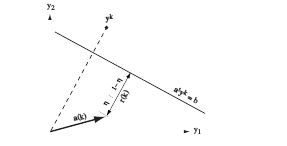

Fig.14: In each step of a basic relaxation algorithm, the weight vector is moved a proportion η of the way towards the hyperplane deﬁned by at yk = b.


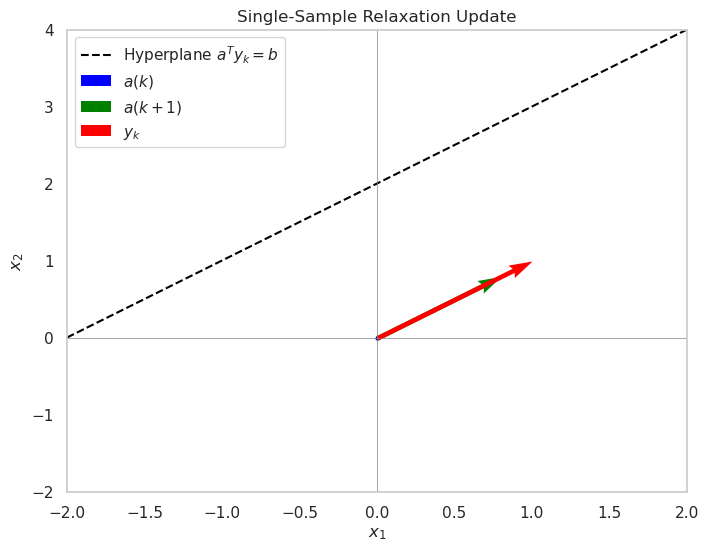

In [5]:

#```python
# Visualization example
import matplotlib.pyplot as plt
import numpy as np

# Hyperplane: y = mx + c
m, c = 1, 2
x_vals = np.linspace(-2, 2, 100)
y_vals = m * x_vals + c

# Vectors a(k), y_k
a_k = np.array([0, 0])  # Initial weight vector
y_k = np.array([1, 1])  # Sample vector
b = 2                   # Margin
eta = 0.8               # Underrelaxation factor

# Update step
r_k = (b - np.dot(a_k, y_k)) / np.linalg.norm(y_k)
a_k1 = a_k + eta * r_k * (y_k / np.linalg.norm(y_k))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_vals, label="Hyperplane $a^T y_k = b$", color="black", linestyle="--")
plt.quiver(0, 0, *a_k, angles='xy', scale_units='xy', scale=1, color='blue', label='$a(k)$')
plt.quiver(0, 0, *a_k1, angles='xy', scale_units='xy', scale=1, color='green', label='$a(k+1)$')
plt.quiver(0, 0, *y_k, angles='xy', scale_units='xy', scale=1, color='red', label='$y_k$')

plt.xlim(-2, 2)
plt.ylim(-2, 4)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.title("Single-Sample Relaxation Update")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.grid()
plt.show()


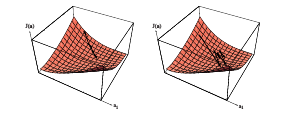

Fig.15: At the left, underrelaxation (η < 1) leads to needlessly slow descent, or even failure to converge. Overrelaxation (1 < η < 2, shown in the middle) describes overshooting; nevertheless convergence will ultimately be achieved.

# Convergence Proof for the Single-Sample Relaxation Algorithm

The relaxation rule ensures that for a set of linearly separable samples:

1. If the number of corrections is finite, the algorithm converges to a solution vector.
2. If the number of corrections is infinite, $ a(k) $ converges to a limit vector on the boundary of the solution region.

---

## Convergence Proof

### Step 1: Reduction of Distance to the Solution Region

Let $ \hat{a} $ be any vector in the solution region such that:
$$
\hat{a}^T y_i > b \quad \forall i
$$

At each step, the distance between $ a(k) $ and $ \hat{a} $ decreases. Using the update rule:
$$
a(k+1) = a(k) + \eta \frac{b - a^T(k)y_k}{\|y_k\|^2} y_k
$$

The squared distance between $ a(k+1) $ and $ \hat{a} $ is:
$$
\|a(k+1) - \hat{a}\|^2 = \|a(k) - \hat{a}\|^2 - 2 \eta \frac{( \hat{a} - a(k))^T y_k}{\|y_k\|^2} (b - a^T(k)y_k) + \eta^2 \frac{(b - a^T(k)y_k)^2}{\|y_k\|^4} \|y_k\|^2
$$

Simplifying:
$$
\|a(k+1) - \hat{a}\|^2 = \|a(k) - \hat{a}\|^2 - \eta(2 - \eta) \frac{(b - a^T(k)y_k)^2}{\|y_k\|^2}
$$

---

### Step 2: Distance Decreases with Each Step

Since:
$$
(\hat{a} - a(k))^T y_k > b - a^T(k)y_k \geq 0
$$

The term $ \eta(2 - \eta) $ is positive for $ 0 < \eta < 2 $. Therefore:
$$
\|a(k+1) - \hat{a}\| \leq \|a(k) - \hat{a}\|
$$

This implies that the sequence $ \{a(k)\} $ gets closer to $ \hat{a} $, with:
$$
\|a(k) - \hat{a}\| \to r(\hat{a}) \quad \text{as } k \to \infty
$$

---

### Step 3: Intersection of Hyperspheres

The limit vector $ a(k) $ is confined to a hypersphere centered at $ \hat{a} $ with radius $ r(\hat{a}) $. Since this is true for any $ \hat{a} $ in the solution region, the limiting $ a(k) $ lies at the intersection of all such hyperspheres.

---

### Step 4: Uniqueness of the Limit Point

Suppose there are two distinct points $ \mathbf{a}_1 $ and $ \mathbf{a}_2 $ in the intersection of these hyperspheres. This would imply:
$$
\|\mathbf{a}_1 - \hat{a}\| = \|\mathbf{a}_2 - \hat{a}\| \quad \forall \hat{a} \text{ in the solution region.}
$$

This would mean the solution region lies in a $ (d - 1) $-dimensional hyperplane, contradicting the assumption that the solution region is $ d $-dimensional.

Thus, the intersection of these hyperspheres is a single point on the boundary of the solution region.

---

## Geometric Interpretation

1. $ a(k) $ moves closer to the boundary hyperplane with each step.
2. The distance $ r(k) $ to the hyperplane decreases:
   $$
   r(k+1) = (1 - \eta) r(k)
   $$
3. If $ \eta = 1 $, $ a(k) $ is moved directly onto the hyperplane.

---

## Final Result

The algorithm converges to a unique limit point on the boundary of the solution region.


Final weights: [0.4807692307692307, 0.5192307692307692]
Number of iterations: 1000


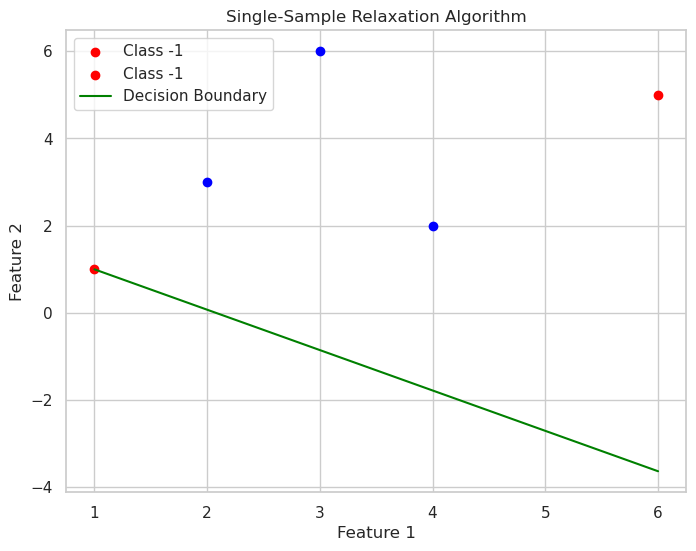

In [6]:
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate the distance of a point from the hyperplane
def distance_from_hyperplane(a, y, b):
    return (b - sum(ai * yi for ai, yi in zip(a, y))) / (sum(yi ** 2 for yi in y) ** 0.5)

# Function to update the weight vector
def update_weights(a, y, b, eta):
    norm_squared = sum(yi ** 2 for yi in y)
    correction_factor = eta * (b - sum(ai * yi for ai, yi in zip(a, y))) / norm_squared
    return [ai + correction_factor * yi for ai, yi in zip(a, y)]

# Single-sample relaxation algorithm with margin
def single_sample_relaxation(data, labels, b=1, eta=0.5, max_iter=1000):
    """
    :param data: List of training samples (list of lists)
    :param labels: List of corresponding labels (+1/-1)
    :param b: Margin
    :param eta: Relaxation factor (0 < eta < 2)
    :param max_iter: Maximum number of iterations
    :return: Final weight vector
    """
    a = [0] * len(data[0])  # Initialize weight vector
    iterations = 0
    
    while iterations < max_iter:
        all_classified = True
        for i in range(len(data)):
            if sum(ai * yi for ai, yi in zip(a, data[i])) <= b:
                a = update_weights(a, data[i], b, eta)
                all_classified = False
        if all_classified:
            break
        iterations += 1
    
    return a, iterations

# Visualization of convergence
def plot_decision_boundary(data, labels, weights, b=1):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Plot the data points
    for point, label in zip(data, labels):
        color = 'red' if label == -1 else 'blue'
        plt.scatter(point[0], point[1], color=color, label=f"Class {label}" if label == -1 else "")

    # Plot the decision boundary
    x_vals = [min(x[0] for x in data), max(x[0] for x in data)]
    y_vals = [(-weights[0] * x + b) / weights[1] for x in x_vals]
    plt.plot(x_vals, y_vals, color='green', label="Decision Boundary")

    plt.title("Single-Sample Relaxation Algorithm")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

# Example dataset
data = [[2, 3], [1, 1], [4, 2], [3, 6], [6, 5]]
labels = [1, -1, 1, 1, -1]

# Run the algorithm
weights, num_iterations = single_sample_relaxation(data, labels, b=1, eta=0.5)
print(f"Final weights: {weights}")
print(f"Number of iterations: {num_iterations}")

# Visualize the result
plot_decision_boundary(data, labels, weights, b=1)
